In [1]:
#import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 18,8
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import seaborn as sns

In [2]:
dateparser = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
dataset = pd.read_csv('C:/Faculta anul 3 sem 2/Licenta/DJIA/CSCO.csv', sep=',', index_col = 'Date', parse_dates = ['Date'], date_parser = dateparser).fillna(0)
dataset.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,38.950001,38.430000,38.669998,38.860001,20135700.0,34.923309
2018-01-03,39.279999,38.529999,38.720001,39.169998,29536000.0,35.201908
2018-01-04,39.540001,38.930000,39.049999,38.990002,20731400.0,35.301498
2018-01-05,39.880001,39.369999,39.549999,39.529999,24588200.0,35.790413
2018-01-08,39.959999,39.349998,39.520000,39.939999,16582000.0,36.161629


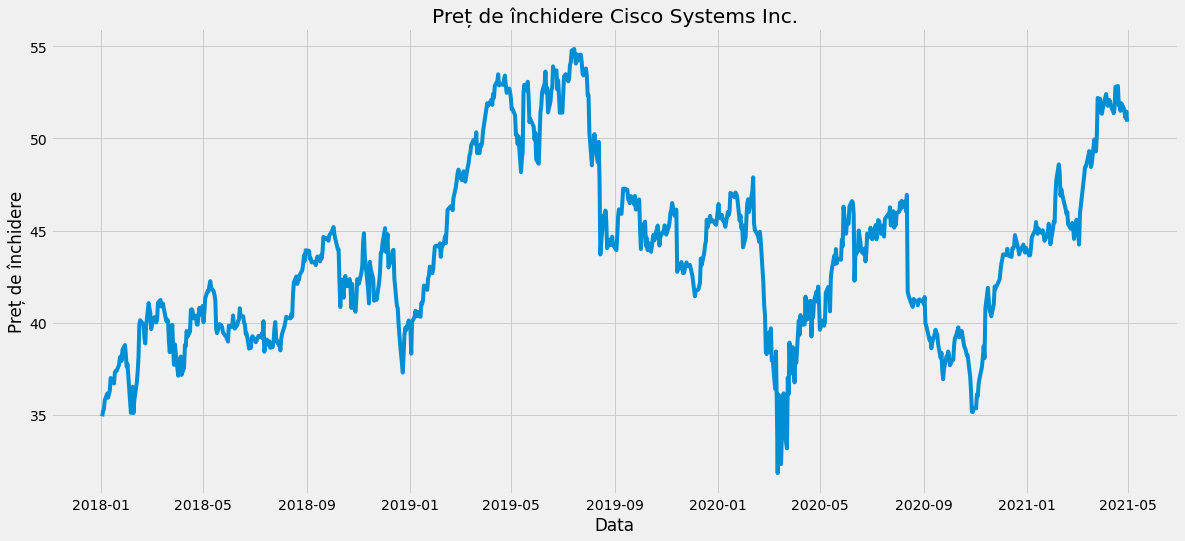

In [3]:
plt.xlabel('Data')
plt.ylabel('Preț de închidere')
plt.plot(dataset['Adj Close'])
plt.title('Preț de închidere Cisco Systems Inc.')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

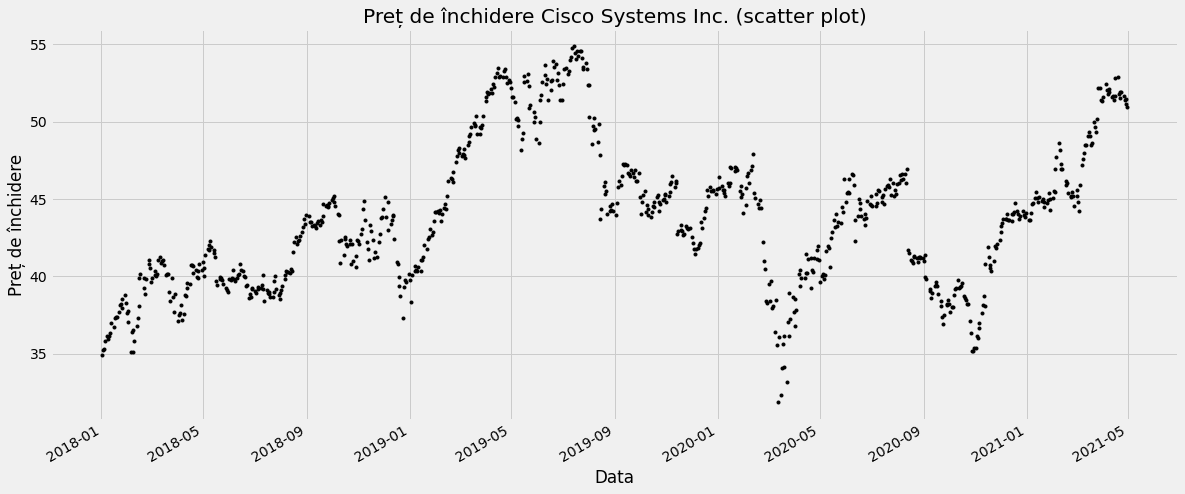

In [4]:
df_close = dataset['Adj Close']
df_close.plot(style='k.')
plt.xlabel('Data')
plt.ylabel('Preț de închidere')
plt.title('Preț de închidere Cisco Systems Inc. (scatter plot)')
plt.show

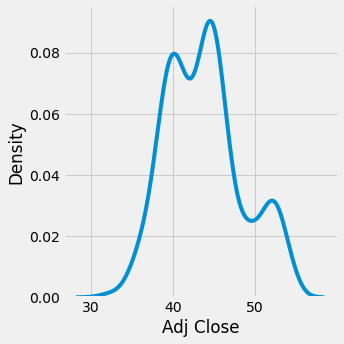

In [5]:
density = sns.displot(dataset, x="Adj Close", kind="kde")

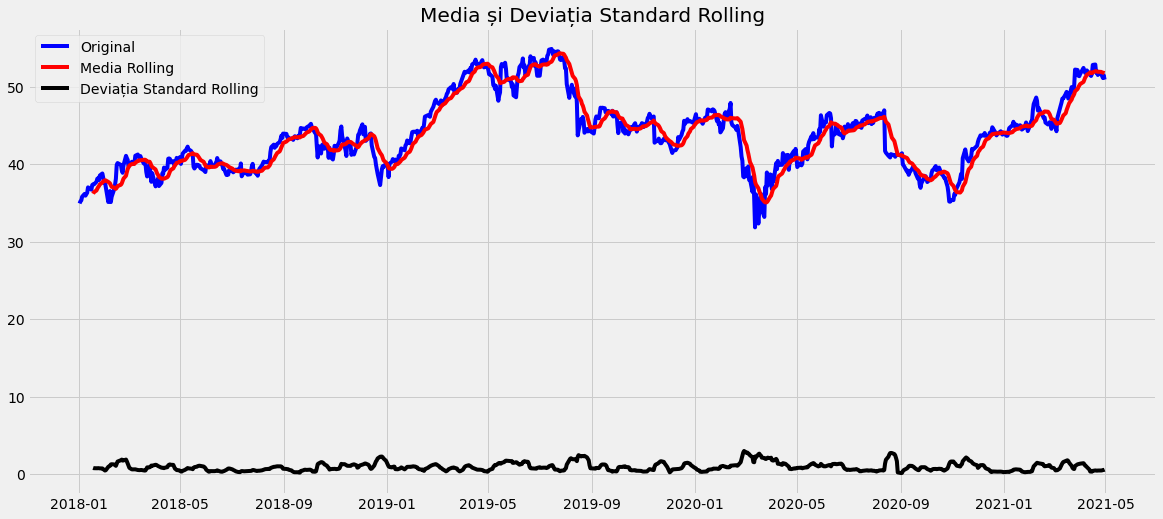

Rezultatele testului Dickey-Fuller Augmentat: 
Test statistic            -2.439188
p-value                    0.130980
Nr. decalaje folosite      9.000000
Nr. observatii           828.000000
valoare critica (1%)      -3.438272
valoare critica (5%)      -2.865037
valoare critica (10%)     -2.568632
dtype: float64


In [6]:
def test_stationarity(timeseries):
    rolling_mean = timeseries.rolling(12).mean()
    rolling_std = timeseries.rolling(12).std()
    plt.plot(timeseries, color = 'blue', label = 'Original')
    plt.plot(rolling_mean, color = 'red', label='Media Rolling')
    plt.plot(rolling_std, color = 'black', label = 'Deviația Standard Rolling')
    plt.legend(loc='best')
    plt.title('Media și Deviația Standard Rolling')
    plt.show(block=False)
    
    print('Rezultatele testului Dickey-Fuller Augmentat: ')
    adft = adfuller(timeseries, autolag = 'AIC')
    results = pd.Series(adft[0:4],index=['Test statistic','p-value','Nr. decalaje folosite','Nr. observatii'])
    for key, value in adft[4].items():
        results['valoare critica (%s)' %key] = value
    print(results)
test_stationarity(df_close)

<Figure size 1296x576 with 0 Axes>

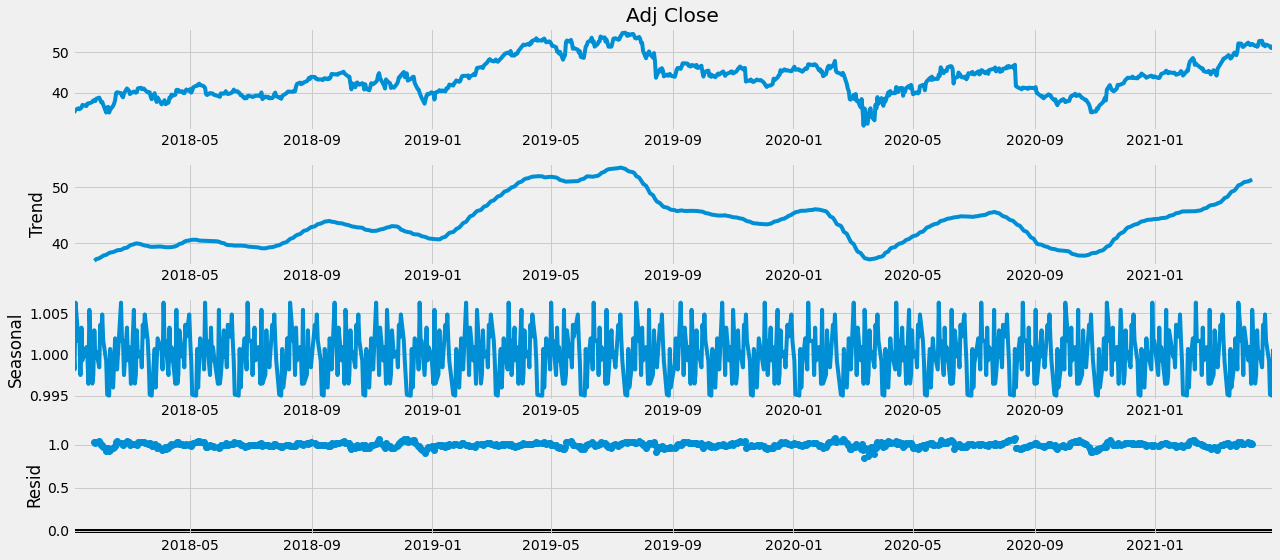

In [7]:
result = seasonal_decompose(df_close, model='multiplicative',freq = 30)
fig = plt.figure()
fig = result.plot()

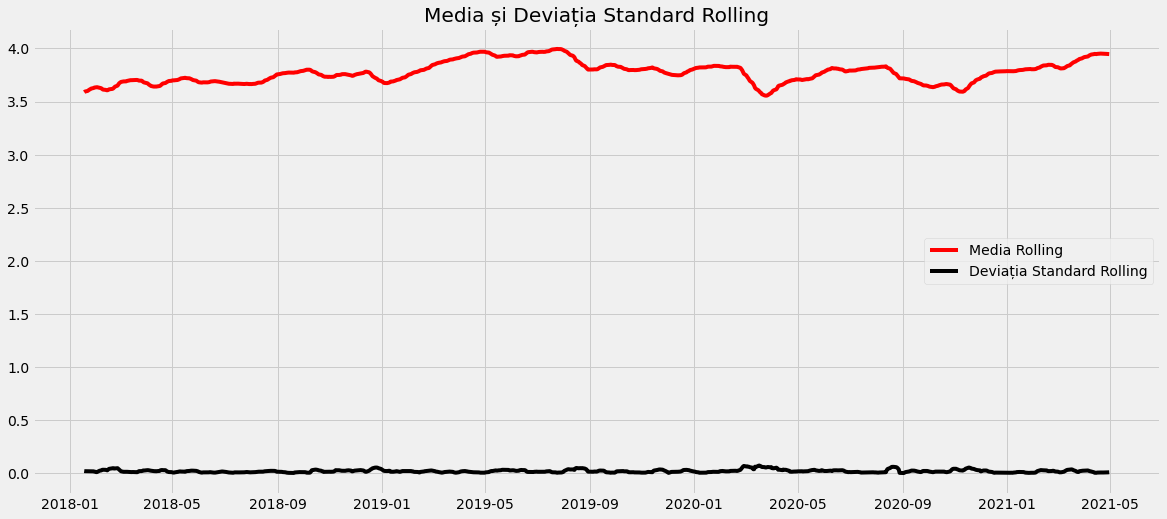

In [8]:
df_log = np.log(df_close)
rolling_mean = df_log.rolling(12).mean()
rolling_std = df_log.rolling(12).std()
plt.title('Media și Deviația Standard Rolling')
plt.plot(rolling_mean, color = 'red', label='Media Rolling')
plt.plot(rolling_std, color = 'black', label = 'Deviația Standard Rolling')
plt.legend(loc='best')
plt.show()

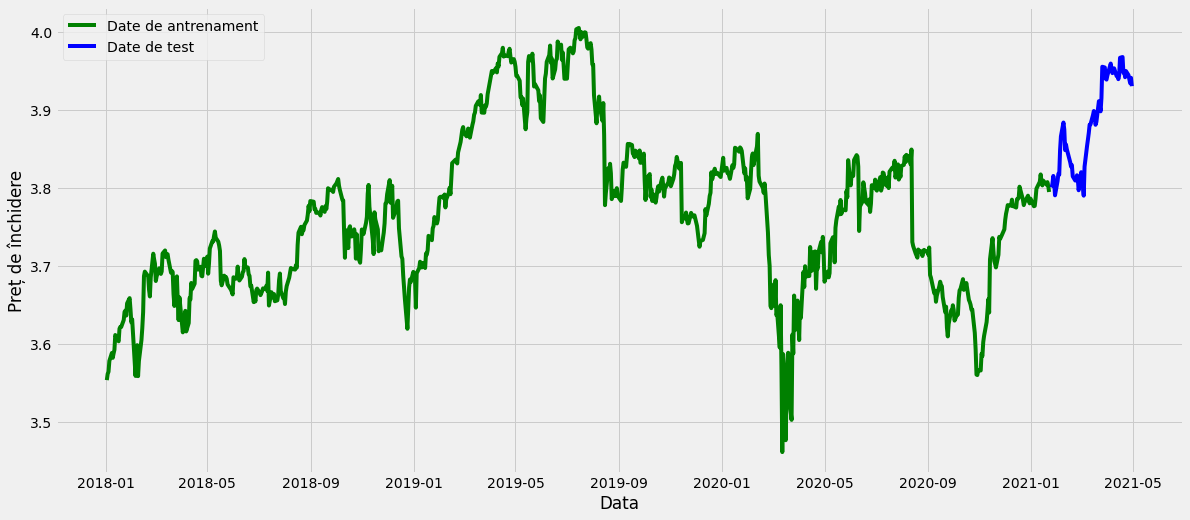

In [9]:
train_data, test_data = df_log[:int(len(df_log)*0.92)], df_log[int(len(df_log)*0.92):]
plt.xlabel('Data')
plt.ylabel('Preț de închidere')
plt.plot(train_data, 'green', label = "Date de antrenament")
plt.plot(test_data, 'blue', label = "Date de test")
plt.legend()

In [10]:
auto_ARIMA = auto_arima(train_data,
                        start_p=0, start_q=0,
                        test = 'adf',
                        max_p=3, max_q=3,
                        m=1,
                        d=None,
                        seasonal=True,
                        start_P=0, 
                        D=0,
                        trace=True,
                        error_action = 'ignore',
                        suppress_warnings=True,
                        stepwise=True,)
print(auto_ARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3832.218, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3861.472, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3859.434, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3834.028, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3859.528, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3859.510, Time=0.64 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3857.595, Time=1.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3863.188, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-3861.249, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3861.230, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-3860.991, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-3859.837, Time=1.31 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 6.051 seconds
                               SARIMAX Results                              

In [12]:
first_diff = train_data - train_data.shift(2)
first_diff = first_diff.dropna(inplace = False)

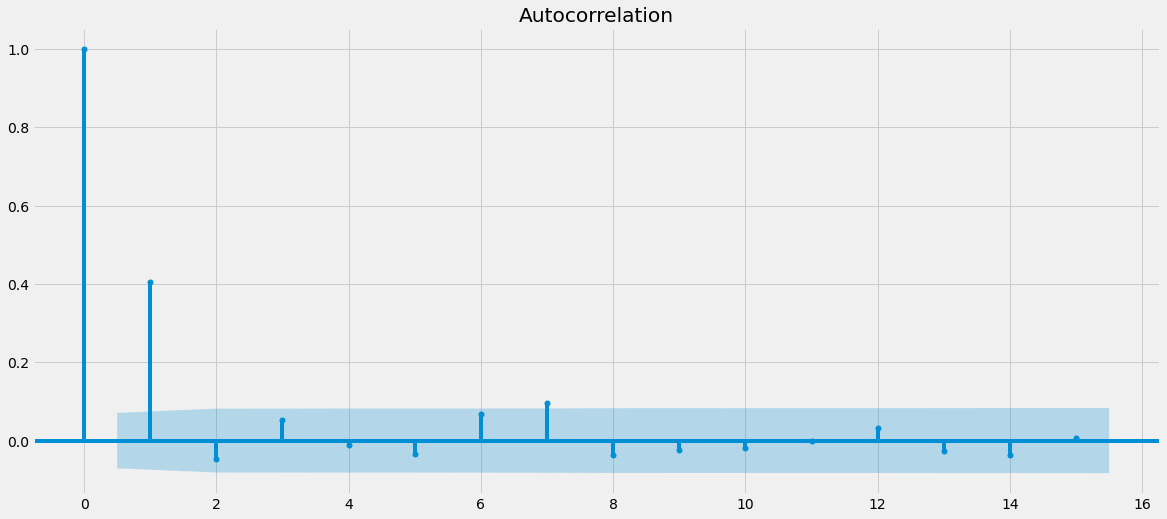

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf_plot = plot_acf(first_diff,lags = 15)

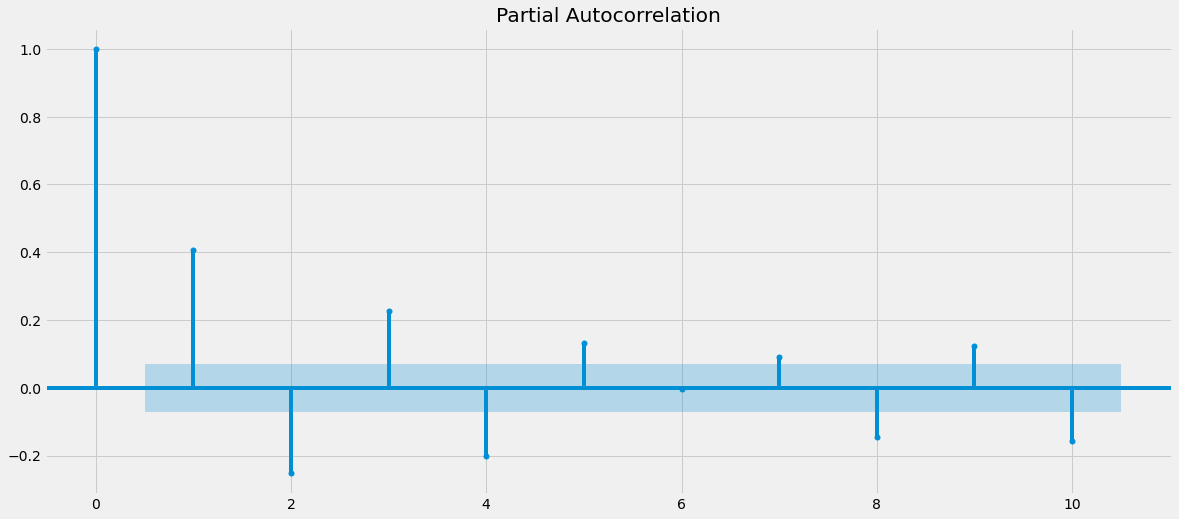

In [14]:
pacf_plot = plot_pacf(first_diff, lags=10)

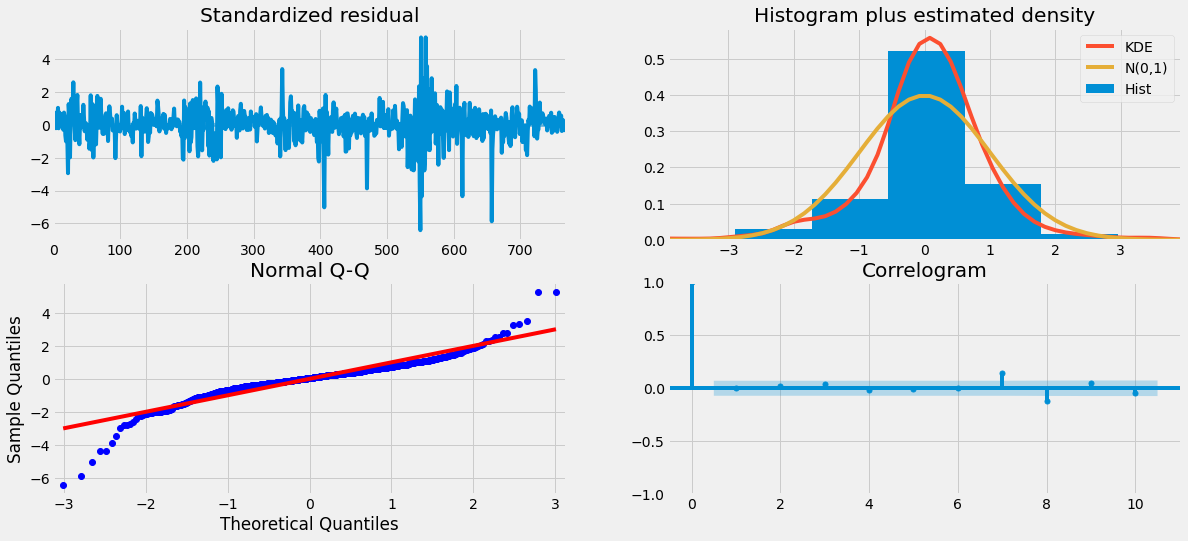

In [11]:
auto_ARIMA.plot_diagnostics()
plt.show()

In [15]:
warnings.filterwarnings('ignore')
model = ARIMA(train_data, order=(0, 2, 1))  
fitted = model.fit(disp=-1,trend=  'nc')  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:           D2.Adj Close   No. Observations:                  768
Model:                 ARIMA(0, 2, 1)   Log Likelihood                1911.792
Method:                       css-mle   S.D. of innovations              0.020
Date:                Tue, 15 Jun 2021   AIC                          -3819.585
Time:                        10:43:07   BIC                          -3810.297
Sample:                             2   HQIC                         -3816.010
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
ma.L1.D2.Adj Close    -1.0000      0.004   -238.086      0.000      -1.008      -0.992
                                    Roots                                    
                  Real       

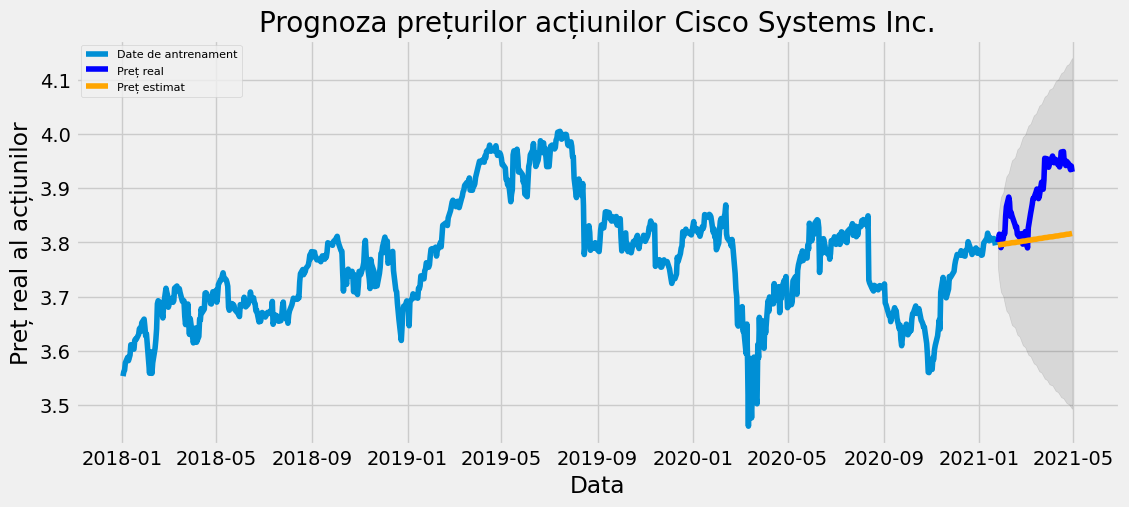

In [16]:
fc, se, conf = fitted.forecast(68, alpha=0.05)
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='Date de antrenament')
plt.plot(test_data, color = 'blue', label='Preț real')
plt.plot(fc_series, color = 'orange',label='Preț estimat')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('Prognoza prețurilor acțiunilor Cisco Systems Inc.')
plt.xlabel('Data')
plt.ylabel('Preț real al acțiunilor')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [18]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: '+str(mse))
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))*100
print('MAPE: '+str(mape))

MSE: 19.88901022466633
MAE: 3.6868697538037205
RMSE: 4.459709656991846
MAPE: 7.311637201236154
